In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import random, math, time
from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


cuda


In [3]:
# df = pd.read_csv('Variant_Apologetic_Emails_with_Abbreviation_Expansion.csv', encoding="latin1")

In [4]:
# df.head()

In [5]:
# # Select only the required columns
# selected_df = df[["Apologetic_Variant_Formal", "Informal"]]

# # (Optional) Save to a new CSV
# selected_df.to_csv("apologetic_informal_only.csv", index=False)

In [6]:
df = pd.read_csv("apologetic_informal_only.csv")

df.head()

,Apologetic_Variant_Formal,Informal
0,I sincerely apologize for the inconvenience. D...,dear all due to the delay in ubs windows accou...
1,I sincerely apologize for the inconvenience. I...,i wanna put this old dog out of its misery bef...
2,My apologies for any trouble caused. Hi there ...,hi there want to see some nasty hot action cum...
3,I sincerely apologize for the inconvenience. H...,hello mark i have attached an outline that wil...
4,I regret any inconvenience caused. Central sta...,cst to brett r peter n tracee cc kelly h sarah...


In [7]:
# # Split: 80% train, 10% val, 10% test
# train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
# val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# train_df.to_csv("train_informal_ap.csv", index=False)
# val_df.to_csv("val_informal_ap.csv", index=False)
# test_df.to_csv("test_informal_ap.csv", index=False)


In [8]:
class EmailToneDataset(Dataset):
    def __init__(self, filepath, tokenizer, max_len=100):
        self.data = pd.read_csv(filepath)
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        apology = "Apologetic: " + self.data.iloc[index]['Apologetic_Variant_Formal']
        informal = self.data.iloc[index]['Informal']

        source = self.tokenizer(apology, padding="max_length", truncation=True, max_length=self.max_len, return_tensors="pt")
        target = self.tokenizer(informal, padding="max_length", truncation=True, max_length=self.max_len, return_tensors="pt")

        return {
            'input_ids': source['input_ids'].squeeze(),
            'attention_mask': source['attention_mask'].squeeze(),
            'labels': target['input_ids'].squeeze()
        }


In [9]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

tokenizer = T5Tokenizer.from_pretrained("t5-base")
model = T5ForConditionalGeneration.from_pretrained("t5-base").to(device)


2025-04-25 05:39:01.338757: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745559541.361249 1454238 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745559541.368199 1454238 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745559541.387284 1454238 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745559541.387298 1454238 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745559541.387300 1454238 computation_placer.cc:177] computation placer alr

In [10]:
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=5e-5)

def train_epoch(model, dataloader):
    model.train()
    total_loss = 0
    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += loss.item()

    return total_loss / len(dataloader)

In [11]:
def evaluate_loss(model, dataloader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()
    return total_loss / len(dataloader)


In [12]:
train_dataset = EmailToneDataset("train_informal_ap.csv", tokenizer)
val_dataset = EmailToneDataset("val_informal_ap.csv", tokenizer)
test_dataset = EmailToneDataset("test_informal_ap.csv", tokenizer)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)
test_loader = DataLoader(test_dataset, batch_size=8)


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch 1 | Train Loss: 0.3770 | Val Loss: 0.0572
Epoch 2 | Train Loss: 0.0546 | Val Loss: 0.0404
Epoch 3 | Train Loss: 0.0416 | Val Loss: 0.0330
Epoch 4 | Train Loss: 0.0338 | Val Loss: 0.0286
Epoch 5 | Train Loss: 0.0292 | Val Loss: 0.0259
Epoch 6 | Train Loss: 0.0250 | Val Loss: 0.0246
Epoch 7 | Train Loss: 0.0223 | Val Loss: 0.0238
Epoch 8 | Train Loss: 0.0203 | Val Loss: 0.0226
Epoch 9 | Train Loss: 0.0185 | Val Loss: 0.0221
Epoch 10 | Train Loss: 0.0171 | Val Loss: 0.0225
Epoch 11 | Train Loss: 0.0153 | Val Loss: 0.0225
Epoch 12 | Train Loss: 0.0141 | Val Loss: 0.0229
Early stopping triggered at epoch 12


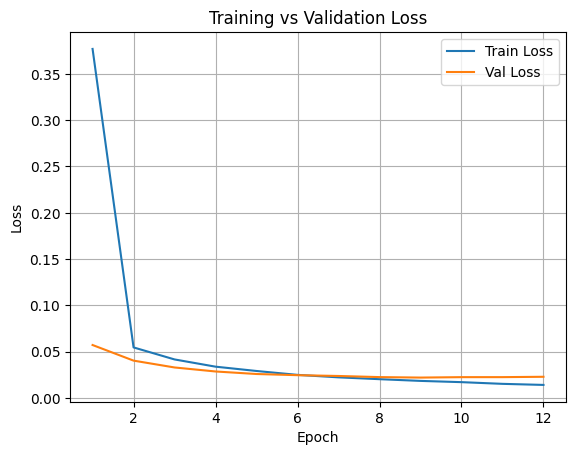

In [13]:
import os
import pandas as pd
import matplotlib.pyplot as plt

train_losses = []
val_losses = []

# Early stopping parameters
best_val_loss = float('inf')
patience = 3
counter = 0

for epoch in range(50):  # You can increase this if needed
    train_loss = train_epoch(model, train_loader)
    val_loss = evaluate_loss(model, val_loader)

    train_losses.append({"epoch": epoch + 1, "loss": train_loss})
    val_losses.append({"epoch": epoch + 1, "loss": val_loss})

    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    # Early stopping logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        # Optionally save the best model
        torch.save(model.state_dict(), "outputs5/best_model.pt")
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

# Save to CSV
os.makedirs("outputs3", exist_ok=True)
pd.DataFrame(train_losses).to_csv("outputs5/train_loss.csv", index=False)
pd.DataFrame(val_losses).to_csv("outputs5/val_loss.csv", index=False)

# Plot both
plt.plot([d['epoch'] for d in train_losses], [d['loss'] for d in train_losses], label='Train Loss')
plt.plot([d['epoch'] for d in val_losses], [d['loss'] for d in val_losses], label='Val Loss')
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.savefig("outputs5/loss_comparison.png")
plt.show()

In [14]:
model.save_pretrained("outputs5/apologetic_informal_rewriter_model_updated")
tokenizer.save_pretrained("outputs5/apologetic_informal_rewriter_model_updated")

('outputs5/apologetic_informal_rewriter_model_updated/tokenizer_config.json',
 'outputs5/apologetic_informal_rewriter_model_updated/special_tokens_map.json',
 'outputs5/apologetic_informal_rewriter_model_updated/spiece.model',
 'outputs5/apologetic_informal_rewriter_model_updated/added_tokens.json')

In [15]:
def rewrite_email(text):
    input_text = "Apologetic: " + text
    inputs = tokenizer(input_text, return_tensors="pt", padding=True).to(device)
    outputs = model.generate(**inputs, max_length=100)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

# Example
informal_text = "I sincerely apologize for the inconvenience. How are you doing"
print("Formal:", rewrite_email(informal_text))


Formal: Hows that going


In [16]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer

nltk.download('punkt')

smooth = SmoothingFunction().method4
rouge = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)


[nltk_data] Downloading package punkt to /home/jupyter-
[nltk_data]     st125404/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [17]:
def evaluate_model(model, tokenizer, dataset, num_samples=100):
    model.eval()

    bleu_scores = []
    rouge1_scores = []
    rouge2_scores = []
    rougeL_scores = []

    with torch.no_grad():
        for i in range(min(num_samples, len(dataset))):
            sample = dataset[i]
            input_ids = sample['input_ids'].unsqueeze(0).to(device)
            attention_mask = sample['attention_mask'].unsqueeze(0).to(device)

            output = model.generate(input_ids=input_ids, attention_mask=attention_mask, max_length=100)
            generated = tokenizer.decode(output[0], skip_special_tokens=True)

            reference = tokenizer.decode(sample['labels'], skip_special_tokens=True)

            # BLEU
            ref_tokens = nltk.word_tokenize(reference)
            gen_tokens = nltk.word_tokenize(generated)
            bleu = sentence_bleu([ref_tokens], gen_tokens, smoothing_function=smooth)
            bleu_scores.append(bleu)

            # ROUGE
            scores = rouge.score(generated, reference)
            rouge1_scores.append(scores['rouge1'].fmeasure)
            rouge2_scores.append(scores['rouge2'].fmeasure)
            rougeL_scores.append(scores['rougeL'].fmeasure)

    print(f"BLEU Score: {sum(bleu_scores) / len(bleu_scores):.4f}")
    print(f"ROUGE-1: {sum(rouge1_scores) / len(rouge1_scores):.4f}")
    print(f"ROUGE-2: {sum(rouge2_scores) / len(rouge2_scores):.4f}")
    print(f"ROUGE-L: {sum(rougeL_scores) / len(rougeL_scores):.4f}")


In [18]:
from transformers import T5ForConditionalGeneration, T5Tokenizer

# model_path = "outputs/formal_rewriter_model"
model_path = "outputs5/apologetic_informal_rewriter_model_updated"
tokenizer = T5Tokenizer.from_pretrained(model_path)
model = T5ForConditionalGeneration.from_pretrained(model_path).to(device)

model.eval()  # Set to eval mode

T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dro

In [19]:
import nltk

nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /home/jupyter-
[nltk_data]     st125404/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [20]:
evaluate_model(model, tokenizer, test_dataset, num_samples=100)


BLEU Score: 0.8874
ROUGE-1: 0.9474
ROUGE-2: 0.9256
ROUGE-L: 0.9474
